Information about data:

                     ->We have the amazon reviews dataset from kaggle
                     
                     ->Reviews are given for the product
                     
                     ->The features of the data were:
                     
                           Id
                           
                           ProductId- unique identifier for the product
                           
                           UserId- unqiue identifier for the user
                           
                           ProfileName
                           
                           HelpfullnessNumerator- number of users who found the review helpful
                           
                           HelpfulnessDenominator- number of users who indicated whether they 
                           found the review helpful or not
                           
                           Score-rating between 1 and 5
                           
                           Time-timestamp for the review
                           
                           Summary- brief summary of the review
                           
                           Text- text of the review
                       
                     -> Based on the score of the review we review we classify them into positive 
                         and negative
                     
                     Number of reviews: 568,454

                     
                    
                     
                  

Objective:
    
        -> Convert the reviews to vectors by using different approaches like Bag of Words, TFIDF,            Average Word2vec,TFIDF-Word2vec and apply the dimensionality reduction technique

Importing the required libraries to process

In [1]:

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn import metrics
from sklearn.metrics import auc,roc_curve
from nltk.stem.porter import PorterStemmer


Using the sqlite3 to read data

In [2]:

con = sqlite3.connect("database.sqlite")

Filtering the reviews with positive and negative based on the score

In [3]:
 
filtereddata = pd.read_sql_query("SELECT * FROM Reviews WHERE Score !=3",con) 

->function to classify reviews into positive and negative based on rating. 

->Here we are considering that reviews with a rating more than 3 are as positive and reviews with rating 

->less than 3 as negative. So considering 3 as the neutral rating, so neglecting the reviews which are give-n 

  with rating of 3

In [4]:

def classify(x):
    if x>3:
        return 'positive'
    return 'negative'

Applying the function on rating(score) in the data

In [5]:

rating = filtereddata['Score']
rating = rating.map(classify)
filtereddata['Score'] = rating

Information about the data:
    
    ->The shape of data
    
    ->dimensionality of data
    
    ->Number of features
    
    ->Sample data

In [6]:

print(filtereddata.shape)
print(filtereddata.ndim)
print(filtereddata.columns)
print(filtereddata.head(5))

(525814, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0         








Exploratory data analysis

Deduplication:removing duplicates

In [7]:

dup = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE Score !=3 AND UserId="AR5J8UI46CURR" ORDER BY ProductId """,con)
dup

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


  ->It shows that same user have 5 reviews at the same time which is not possible
  
  ->This is because if we review on product it is applied to different flavors in the product  

  ->In order to remove the product we have to sort them and drop the duplicates

In [8]:

sorteddata = filtereddata.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')


In [9]:
finaldata = sorteddata.drop_duplicates(subset=('Time','Text','ProfileName','UserId'),keep='first',inplace=False)

In [10]:
finaldata.shape

(364173, 10)

Percentage reduction of data after dropping duplicates

In [11]:

print(filtereddata['Id'].size)
print(finaldata['Id'].size)

525814
364173


In [12]:
(364173/525814)*100

69.25890143662969

->One more observation is that for a product the useful review(helpfullnessnumerator) is greater that the

->Total number of reviews on the product(helpfullnessdenominator) which is not possible

In [13]:

numden = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 AND Id=44737 OR Id = 64422 ORDER BY ProductId""",con)

In [14]:
numden

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
finaldata = finaldata[finaldata.HelpfulnessNumerator<=finaldata.HelpfulnessDenominator]
finaldata

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138694,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,positive,1338249600,Must have.,I set aside at least an hour each day to read ...
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,positive,1325721600,A classic,I remembered this book from my childhood and g...
138696,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,positive,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....
138697,150515,0006641040,A2RTT81R6Y3R7X,Lindylu,0,0,positive,1303171200,One of our family's favorite books,This book is a family favorite and was read to...


In [16]:
finaldata.shape

(364171, 10)

Text preprocessing:
    ->Which includes cleaning the text like

    ->Removing special characters,stemming,lemitization

    ->Checking a word length greater that 2

    ->Removing stopwords

    ->converting words to lowercase


In [17]:

import re
i=0
for sent in finaldata['Text'].values:
    if(len(re.findall("<.*?>",sent))):
        print(i)
        print(sent)
        break
    i =i+1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [18]:

import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vthumati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

->Removing stop words

->Stemming the words

In [20]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

Function to clean html tags and special characters

In [21]:

def cleanhtml(sentence):
    clean = re.compile("<.*?>")
    cleantext = re.sub(clean," ",sentence)
    return cleantext
def cleanpunct(sentence):
    cleanr = re.sub(r"[?|!|\|'|#|.|,|)|(|/]",r' ',sentence)
    return cleanr

In [22]:
print(sno.stem('because'))
print(stop)

becaus
{'hasn', 'above', 'don', 'or', 'himself', 'am', "doesn't", 'his', 'themselves', 'any', 'through', 'be', 'an', "shouldn't", 'me', 'their', 'up', 'out', 'do', 'during', 'did', 'them', 'into', "you've", 'we', "she's", 'before', "isn't", 'same', 'there', 'below', 'other', 'this', "it's", 'if', 'only', 'of', 'they', 'having', 'to', 'couldn', "weren't", 're', 'myself', "hadn't", 'yours', "you're", 'which', 'against', 'aren', 'm', 'once', 'was', 'again', 'very', 'after', 'were', 'as', 'those', 'from', 'her', 'over', 'each', 'then', 'all', 'further', 'should', 'mightn', 'no', 'weren', "should've", 'down', 'about', 'o', 'and', 'by', 'what', 't', 'does', 'both', 'nor', "mightn't", 'between', 'i', 'in', 'most', "didn't", 'needn', 'a', 'hadn', 'few', 'ma', 'the', 'now', 'on', 'herself', 'such', 'not', 'my', 'is', 've', "you'll", 'has', 'theirs', 'some', 'she', 'doesn', 'than', 'with', 'wouldn', 'isn', 'you', 'more', 'just', "hasn't", "wasn't", 'too', 'your', 'have', 'own', 'ourselves', 'was

In [23]:
i=0
final_string=[]
all_positive_words=[]
all_negative_words=[]
str1=' '
s=' '
for sent in finaldata['Text'].values:
    sent = cleanhtml(sent)
    filtered_sentence=[]
    for w in sent.split():
        for word in cleanpunct(w).split():
            if((word.isalpha()) & (len(word)>2)):
                 if(word.lower() not in stop):
                        s = (sno.stem(word.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if(finaldata['Score'].values)[i]=='positive':
                            all_positive_words.append(s)
                        if(finaldata['Score'].values)[i]=='negative':
                            all_negative_words.append(s)
                            
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i = i+1

In [24]:
len(final_string)

364171

BAG OF WORDS:
    
        Using bow to convert text to vector and reducing its dimensionality

In [25]:

count_vect = CountVectorizer()

In [26]:
final_count = count_vect.fit_transform(finaldata['Text'].values)

In [27]:

print(type(final_count))

final_count.shape

<class 'scipy.sparse.csr.csr_matrix'>


(364171, 115281)

In [28]:
print(type(final_count))

final_count.shape

<class 'scipy.sparse.csr.csr_matrix'>


(364171, 115281)

Applying TRUNCATEDSVD technique on bag of words data to reduce dimensionality

In [29]:

from sklearn.decomposition import TruncatedSVD

In [30]:
truncatedsvd = TruncatedSVD(n_components=2,n_iter=100,random_state=999,tol=0.0)

In [31]:
tsvd = truncatedsvd.fit_transform(final_count)

In [32]:
print(tsvd.shape)
print(type(tsvd.shape))

(364171, 2)
<class 'tuple'>


In [33]:
score = finaldata['Score']
print(score.head(5))

138706    positive
138688    positive
138689    positive
138690    positive
138691    positive
Name: Score, dtype: object


In [34]:
score.shape

(364171,)

In [35]:
tsvddata = np.vstack((tsvd.T,score)).T

In [36]:
tsvddata.shape

(364171, 3)

In [37]:
tsvddatadf=pd.DataFrame(data=tsvddata,columns=('1stdim','2nddim','score'))

In [38]:
import seaborn as s


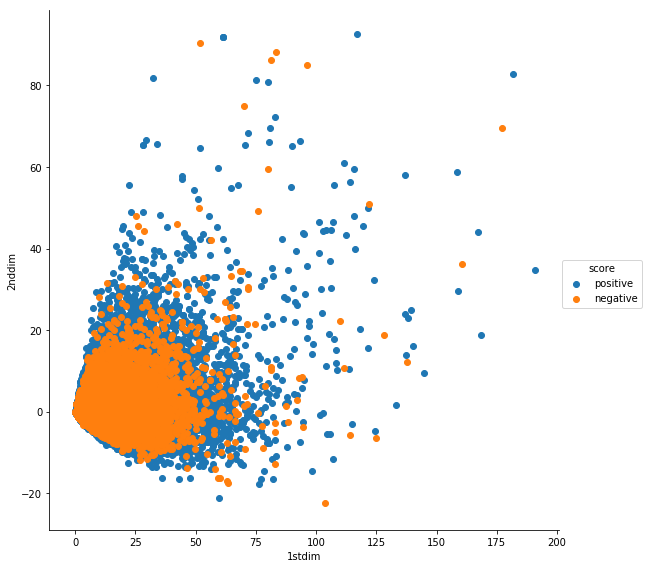

In [39]:

s.FacetGrid(tsvddatadf,hue='score',size=8).map(mp.scatter,'1stdim','2nddim').add_legend()
mp.show()

TF-IDF
      
      Using TF-IDF to convert text to vector and reducing its dimensionality

In [40]:

tf_idf = TfidfVectorizer(ngram_range=(1,2))

In [41]:
tf_idf_vector = tf_idf.fit_transform(finaldata['Text'].values)

In [42]:
print(tf_idf_vector.get_shape())

(364171, 2910192)


In [43]:
type(tf_idf_vector)

scipy.sparse.csr.csr_matrix

->After converting the reviews to vectors using tfidf the resultant is a sparse matrix

->So i have to go with truncatedsvd method for dimensionality redcution

In [44]:

svd1 = TruncatedSVD(n_components=2,n_iter=100,random_state=888,tol=0.0)

In [45]:
svd1_data = svd1.fit_transform(tf_idf_vector)

In [46]:
print(svd1_data.shape)
print(type(svd1_data))

(364171, 2)
<class 'numpy.ndarray'>


In [47]:
score.shape

(364171,)

In [48]:
svd1_dataframe = np.vstack((svd1_data.T,score)).T

In [49]:
svd1_dataframe.shape

(364171, 3)

In [50]:
svd1_df = pd.DataFrame(svd1_dataframe,columns=('dim1','dim2','rating'))

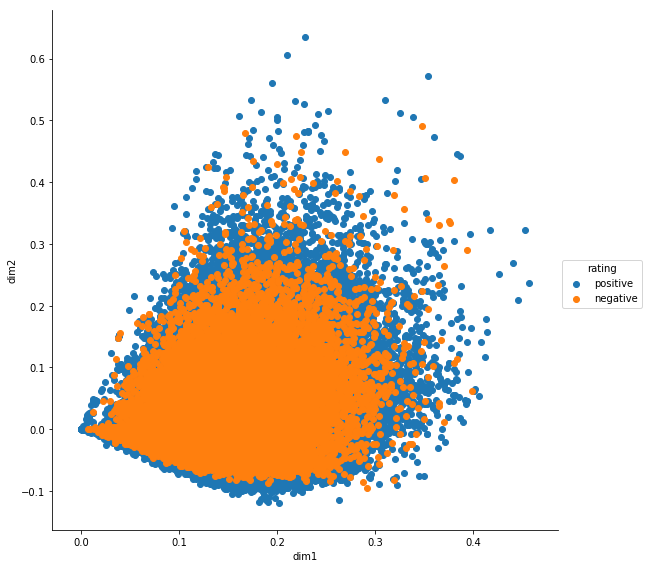

In [51]:
s.FacetGrid(svd1_df,hue='rating',size=8).map(mp.scatter,'dim1','dim2').add_legend()
mp.show()

WORD2VEC:
    
    -> Uisng word2vec approach to convert the words in sentences 

In [52]:
import gensim
from gensim.models import word2vec
from gensim.models import keyedvectors

Constructing our own word2vec model with available data by cleaning the data

In [53]:
i=0
listofsent=[]
for sent in finaldata['Text'].values:
    filtered_sentences = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleanedwords in cleanpunct(w).split():
            if(cleanedwords.isalpha()):
                filtered_sentences.append(cleanedwords.lower())
    listofsent.append(filtered_sentences)   
    

In [54]:
print(len(listofsent))

364171


In [55]:
listofsent[364170]

['i',
 'purchased',
 'this',
 'to',
 'send',
 'to',
 'my',
 'son',
 'who',
 's',
 'away',
 'at',
 'college',
 'it',
 'was',
 'delivered',
 'right',
 'to',
 'his',
 'dorm',
 'room',
 'with',
 'very',
 'fast',
 'shipping',
 'he',
 'loved',
 'it',
 'so',
 'much',
 'he',
 'called',
 'me',
 'to',
 'thank',
 'me',
 'and',
 'sadly',
 'he',
 'hardly',
 'ever',
 'calls',
 'me',
 'anymore',
 'if',
 'you',
 'want',
 'your',
 'kids',
 'to',
 'call',
 'home',
 'and',
 'have',
 'some',
 'good',
 'snack',
 'to',
 'get',
 'them',
 'through',
 'midterms',
 'then',
 'send',
 'them',
 'this']

In [56]:
finaldata['Text'][7]

'This taffy is so good.  It is very soft and chewy.  The flavors are amazing.  I would definitely recommend you buying it.  Very satisfying!!'

In [57]:
w2vmodel = gensim.models.Word2Vec(listofsent,min_count=4,size=50,workers=4)

In [58]:
print(w2vmodel.most_similar('the'))
print(len(w2vmodel.wv.vocab))

[('which', 0.5728905200958252), ('each', 0.5433917045593262), ('their', 0.5308894515037537), ('this', 0.5060376524925232), ('my', 0.48464125394821167), ('simply', 0.45643067359924316), ('flat', 0.4529053568840027), ('clear', 0.45220744609832764), ('eruption', 0.4510941803455353), ('delicateness', 0.44709208607673645)]
37022


/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


We can get similar words and the percentage of relationship between the words

In [59]:

print(w2vmodel.most_similar('care'))

[('know', 0.6655935645103455), ('understand', 0.6083115935325623), ('realize', 0.6025015711784363), ('complain', 0.586801290512085), ('notice', 0.5743852257728577), ('mind', 0.5673655271530151), ('forget', 0.5611222386360168), ('mean', 0.56031334400177), ('wonder', 0.5506972670555115), ('think', 0.5449468493461609)]


/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [60]:
w2vmodel.similarity('care','cares')

/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.4535463963042511

In [61]:
w2vmodel.wv['the']

array([ 1.4760077 ,  0.06088085,  0.25122893,  3.8024113 , -0.7325647 ,
        0.3348562 , -1.227128  ,  1.0383446 ,  1.9653679 , -0.9013535 ,
       -3.3546283 , -2.7682312 ,  0.5758802 , -1.1963058 ,  0.10881724,
        0.01830601, -1.3414948 , -0.9830876 ,  0.05742005, -0.82297766,
       -1.5509261 , -3.6913466 ,  0.44190043, -1.0714308 , -3.6228158 ,
        0.5253932 ,  0.83740276, -0.7880022 ,  0.03580055,  4.513867  ,
       -0.81963825, -3.9849663 ,  0.4207909 ,  1.086782  ,  2.1443024 ,
       -0.9370693 , -1.7344187 ,  1.9087057 , -0.75689244,  1.077857  ,
        2.7157898 ,  1.0272412 , -0.1846602 ,  0.9406825 , -1.04837   ,
       -0.8381365 , -0.36185342,  1.3645554 ,  0.17003968,  1.6306833 ],
      dtype=float32)

Observation:
    
    -> We can train our own model with the available data, in which we can specify the number of dimensions for each
       word

    -> By using word2vec we can the similarity between the words and also most similar words for the given word

    -> We get each word in the form of 45-dimension vector representation

AVERAGE WORD2VEC:
    
    Using word2vec model and average word2vec to convert sentences to vectors and applying dimensionality reduction technique

In [62]:

sent_vectors = []
for sent in listofsent: 
    sent_vec = np.zeros(50) 
    cnt=0
    for word in sent:
        try:
            vec = w2vmodel.wv[word]
            sent_vec += vec
            cnt += 1
        except:
            pass
    sent_vec /= cnt
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[8]))

/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


364171
50


In [63]:
print(len(sent_vectors))
print(len(sent_vectors[9999]))

364171
50


In [64]:
type(sent_vectors)

list

In [65]:
sent_vectors[364170]

array([ 0.36570453,  0.09334156,  0.98163805,  0.73257641,  0.27443594,
       -0.30483963,  0.25059458,  0.2841531 ,  0.6156666 ,  0.60540936,
       -0.6850321 , -0.7704277 , -0.85955792, -0.36570157, -0.9139018 ,
        0.32033311,  0.59219124, -0.99978455, -0.30295844, -0.67316759,
        0.54540802, -0.16040993, -0.29966747, -0.04598839, -0.43404739,
        0.31542922, -0.54752204,  1.77304547, -0.80832378,  0.59803742,
       -0.11124071, -1.02951697,  0.90932121,  0.23180143,  0.71062997,
        0.70429823,  1.17052499,  1.51756817,  0.07588771, -0.82052859,
        1.08738133, -0.92131361,  0.33412902, -0.24660408, -0.38576354,
        0.39805261,  0.89788988, -1.67742117, -0.45916062, -0.52337357])

In [66]:
np.isnan(sent_vectors).any()

True

In [67]:
np.nansum(sent_vectors)

-157262.27503916554

In [68]:
type(sent_vectors)

list

In [69]:
from sklearn.decomposition import TruncatedSVD

In [70]:
tsvd = TruncatedSVD(n_components=2,tol=0.0,random_state=555)

In [72]:
sent_vectors = np.nan_to_num(sent_vectors)

In [73]:
print(sent_vectors.shape)
print(len(sent_vectors))

(364171, 50)
364171


In [75]:
np.isnan(sent_vectors).any()

False

In [74]:
from sklearn.decomposition import TruncatedSVD

In [76]:
truncatedsvd = TruncatedSVD(n_components=2,tol=0.0,random_state=4)

In [77]:
tsvd_data = truncatedsvd.fit_transform(sent_vectors)

In [78]:
tsvd_data.shape

(364171, 2)

In [79]:
score.shape

(364171,)

In [80]:
tsne_data_avgw2vec = np.vstack((tsvd_data.T,score)).T

In [81]:
tsne_data_avgw2vec.shape

(364171, 3)

In [82]:
tsne_data_avgw2vec_df = pd.DataFrame(data=tsne_data_avgw2vec,columns=("Dimension-1",'Dimension-2','label'))

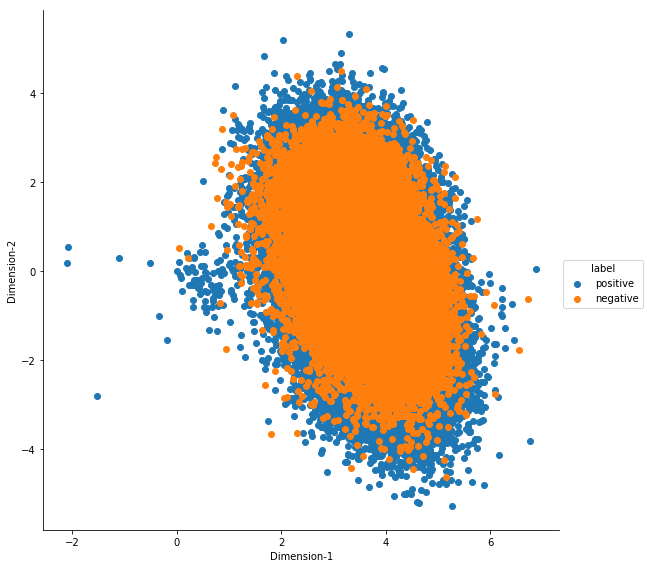

In [83]:
s.FacetGrid(tsne_data_avgw2vec_df,hue="label",size=8).map(mp.scatter,'Dimension-1','Dimension-2').add_legend()
mp.show()

Observation:
    
    -> We have constructed the word2vec for each word with the available data
    
    -> Using the word2vec model for each word we have constructed the vector representation of each sentence
    
    -> By using t-SNE dimensionality reduction technique we have reduced it to 2-dimension representation

TFIDF-W2V:
    
    -> This is an alternative for the average word2vec representation
    
    -> Using this model with the help of the word2vec model we construct the vector representation of each sentence
    
    -> Applying dimensionality reduction technique to reduce the dimensions of each sentences

In [84]:
tf_idf_features = tf_idf.get_feature_names()
print(len(tf_idf_features))

2910192


In [85]:
tfidf_sent_vec = []
row=0
for sent in listofsent:
        sent_vector = np.zeros(50) 
        sum =0
        for word in sent: 
            try:
                vec = w2vmodel.wv[word]
                tf_idf = tf_idf_vector[row, tfidf_features.index(word)]
                sent_vec += (vec * tf_idf)
                sum += tf_idf
            except:
                pass
        sent_vec /= sum
        tfidf_sent_vec.append(sent_vector)
        row += 1

/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [86]:
len(tfidf_sent_vec)

364171

In [87]:
len(tfidf_sent_vec[99999])

50

In [88]:
np.isnan(tfidf_sent_vec).any()

False

In [89]:
type(tfidf_sent_vec)

list

In [90]:
tfidf_sent_vec = np.nan_to_num(tfidf_sent_vec)

In [91]:
tfidf_sent_vec.shape

(364171, 50)

In [92]:
len(tfidf_sent_vec)

364171

In [93]:
type(tfidf_sent_vec)

numpy.ndarray

In [94]:
from sklearn.decomposition import TruncatedSVD

In [95]:
tsvd_tfidf_avgw2v = TruncatedSVD(n_components=2,n_iter=200,tol=0.0,random_state=8)

In [96]:
tsvd_tfidf_avgw2v_data = tsvd_tfidf_avgw2v.fit_transform(tfidf_sent_vec)

/Users/vthumati/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:192: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [98]:
print(tsvd_tfidf_avgw2v_data.shape)
print(len(tsvd_tfidf_avgw2v_data))
print(score.shape)

(364171, 2)
364171
(364171,)


In [100]:
tsne_data_tfidf_avgw2vec = np.vstack((tsvd_tfidf_avgw2v_data.T,score)).T

In [101]:
tsne_data_tfidf_avgw2vec_df = pd.DataFrame(data=tsne_data_avgw2vec,columns=("Dimension-1",'Dimension-2','label'))

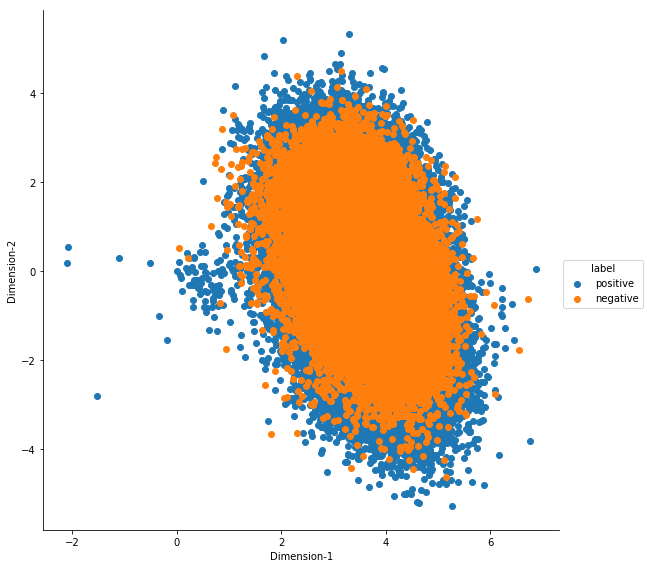

In [102]:
s.FacetGrid(tsne_data_tfidf_avgw2vec_df,hue="label",size=8).map(mp.scatter,'Dimension-1','Dimension-2').add_legend()
mp.show()

Sample example for constructing tfidf-word2vec of a word

In [106]:

print(tf_idf_vector[0,tf_idf_features.index('in')])
print(w2vmodel.wv['in'])
a = tf_idf_vector[0,tf_idf_features.index('in')]
b = w2vmodel.wv['in']
c = a*b
print(c)

0.03277183177760655
[ 2.0197868   1.584507    0.5037021   0.8123775   0.22914465  0.39732596
  0.6230064  -1.964715    0.6152098   3.4045718  -1.2768095   0.684145
  1.1673226  -0.05719063  2.8159833  -2.1201591   1.2506253   1.832313
  1.1778784  -1.3166465  -3.5585659  -3.6476698  -3.0662668  -3.2881083
  0.50599736  2.845872    0.02283531  0.16117303 -0.4806304   1.9380871
  1.727675   -2.8744116  -1.0183523   0.12740374 -2.1708148   0.57003117
 -0.9761366  -0.798371   -5.5048757   2.6155515  -1.239809    0.6248961
  0.8735584  -1.6617626  -2.1666777  -0.6809082   0.8801965  -3.4966476
 -4.1194386   0.33846864]
[ 0.06619212  0.0519272   0.01650724  0.0266231   0.00750949  0.0130211
  0.02041706 -0.06438731  0.02016155  0.11157406 -0.04184339  0.02242069
  0.0382553  -0.00187424  0.09228493 -0.0694815   0.04098528  0.06004825
  0.03860123 -0.04314892 -0.11662073 -0.11954083 -0.10048718 -0.10775734
  0.01658246  0.09326444  0.00074835  0.00528194 -0.01575114  0.06351466
  0.05661907 -

Observation:
    
    -> The alternate strategy to construct sentence vectors is TFIDF-WORD2vec

    -> It computes the tfidf vector for text and then it computes the word2vec for the text

    -> The result is the average of product of tfidf vector and word2vec vector to the tfidf vector
    
    -> We can apply the dimensionality reduction technique on the result

Conclusion:
    
    -> For the given dataset we have constructed the vector representation by using techniques  
       like Bag of words,TFIDF, Average word2vec, TFIDF-Word2vec
        
    -> Dimensionality reduction technique is applied on each of these techniques.
    
    -> Based on the polarity of the class labels.
    
    -> By applying the dimensionality reduction technique on each of these representations to 
       reduce the dimensions from n to 2-dimensions